# Introduction

A business man wants to start a new restaurant business in North America and after researching, he has narrowed down to two cities: New York and Toronto. Both cities are very diverse and are the financial capitals of their respective countries. So he decided to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. Then he can have more useful information on making decisions.

# Data

We will be using neighborhoods data of these two cities from Foursquare API for fetching and exploring all sorts of restaurant-like venues. For New York, we are using the New York data from previous lab and for Toronto, we will be webscraping the data from Wikipdia plus the coordinates data from previous lab. We will choose one borough from each city: Manhattan for New York and Downtown for Toronto and apply Neighborhood Segmentation and Clustering to analyze the neighborhood data and prioritize the best restaurant location in both cities.

# Methodology

We will be exploring two cities one by one with the same methodology. After we extract the data for both cities, we will explore them by using Foursquare API and visualize the results separately.

Start by importing the libraries that we need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Get the Manhattan neighborhood data.

In [2]:
#!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Visualize Manhattan neighborhoods. 

In [3]:
address = 'Manhattan, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_m = location.latitude
longitude_m = location.longitude

# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude_m, longitude_m], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Get the Downtown Toronto neighborhood data.

In [4]:
from bs4 import BeautifulSoup

html_data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(html_data, 'html5lib')
#soup.title

table_contents = [] # Firstly create a list
table = soup.find('table')
for row in table.findAll('td'):
    cell = {} # create a dictionary called cell having 3 keys PostalCode, Borough and Neighborhood
    if row.span.text == 'Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3] # As postal code contains upto 3 characters extract that using tablerow.p.text
        cell['Borough'] = (row.span.text).split('(')[0] # use split ,strip and replace functions for getting Borough and Neighborhood information
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell) # Append to the list

# print(table_contents)
df = pd.DataFrame(table_contents) # Create a dataframe with list
df['Borough'] = df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df = df[['PostalCode', 'Borough', 'Neighborhood']]

df_coord = pd.read_csv('Geospatial_Coordinates.csv')
df_coord.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
df = df.merge(df_coord, how='inner', on='PostalCode')
df = df.drop('PostalCode', 1)
toronto_data = df[df['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
toronto_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,Downtown Toronto,St. James Town,43.651494,-79.375418
3,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,Downtown Toronto,Central Bay Street,43.657952,-79.387383


Visualize Downtown Toronto neighborhoods.

In [5]:
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode('Toronto')
latitude_t = location.latitude
longitude_t = location.longitude

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude_t, longitude_t], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

We will be using the Foursquare API to explore the venues in neighborhoods with setting the limit as 50 venues and the radius 500 meter based on latitude and longitude of each Borough.

In [6]:
CLIENT_ID = 'NMLGOTEJYH4CBUXKC2WLSAZDW2TOJRS1URUABFVVPW1EOWQK'
CLIENT_SECRET = 'OG54ANEXKP20O1Q1P5SWQCZ1LA0V2T5XV1BCNC2GNTLFOPXL'
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # A default Foursquare API limit value

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
manhattan_venues = getNearbyVenues(manhattan_data['Neighborhood'], manhattan_data['Latitude'], manhattan_data['Longitude'])
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym


In [9]:
toronto_venues = getNearbyVenues(toronto_data['Neighborhood'], toronto_data['Latitude'], toronto_data['Longitude'])
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [10]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
manhattan_onehot.insert(0, 'Neighborhood', manhattan_onehot.pop('Neighborhood'))

# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.shape

(40, 275)

In [11]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
toronto_onehot.insert(0, 'Neighborhood', toronto_onehot.pop('Neighborhood'))

# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.shape

(17, 175)

Create a new dataframe and display the top 10 venues for each neighborhood.

In [12]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_M = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_M['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted_M.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_M.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Memorial Site,BBQ Joint,Food Court,Hotel,Gourmet Shop,Plaza,Italian Restaurant,Sandwich Place
1,Carnegie Hill,Café,Bookstore,Yoga Studio,Gym / Fitness Center,French Restaurant,Cocktail Bar,Coffee Shop,Gym,Pizza Place,Wine Shop
2,Central Harlem,African Restaurant,Chinese Restaurant,American Restaurant,Bar,French Restaurant,Gym / Fitness Center,Seafood Restaurant,Pizza Place,Library,Spa
3,Chelsea,Coffee Shop,Ice Cream Shop,Hotel,Italian Restaurant,French Restaurant,Cupcake Shop,Market,Nightclub,American Restaurant,Seafood Restaurant
4,Chinatown,Chinese Restaurant,Hotpot Restaurant,Ice Cream Shop,Boutique,American Restaurant,Spa,Bakery,Sandwich Place,Salon / Barbershop,Asian Restaurant


In [13]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_T = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_T['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted_T.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_T.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Pharmacy,Cheese Shop,Seafood Restaurant,Farmers Market,Cocktail Bar,Restaurant,Beer Bar,Comfort Food Restaurant
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Airport,Harbor / Marina,Plane,Rental Car Location,Boutique,Boat or Ferry,Sculpture Garden
2,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Yoga Studio,Comic Shop,Ice Cream Shop,Modern European Restaurant,Salad Place
3,Christie,Grocery Store,Café,Park,Restaurant,Baby Store,Coffee Shop,Candy Store,Nightclub,Athletics & Sports,Italian Restaurant
4,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Yoga Studio,Men's Store,Restaurant,Creperie,Dance Studio,Sake Bar,Indian Restaurant


I will use K-means clustering to analyze the neighborhood and use the elbow method to determine the best "K".

In [14]:
#pip install yellowbrick --user
from yellowbrick.cluster import KElbowVisualizer

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,11), locate_elbow=False)
visualizer.fit(manhattan_grouped_clustering)
visualizer.poof()

<Figure size 800x550 with 2 Axes>

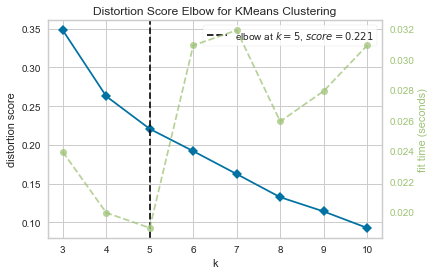

In [15]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,11))
visualizer.fit(toronto_grouped_clustering)
visualizer.poof()

Run K-means to cluster the neighborhood into 5 clusters.

In [16]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_m = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_m.labels_[0:10] 

array([1, 2, 2, 2, 3, 2, 1, 3, 2, 2])

In [17]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_t = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_t.labels_[0:10] 

array([4, 3, 1, 2, 1, 4, 4, 4, 1, 4])

# Results

Visualize the resulting clusters.

In [18]:
# add clustering labels
neighborhoods_venues_sorted_M.insert(0, 'Cluster Labels', kmeans_m.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted_M.set_index('Neighborhood'), on='Neighborhood')

# create map
map_clusters_m = folium.Map(location=[latitude_m, longitude_m], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_m)
       
map_clusters_m

In [19]:
# add clustering labels
neighborhoods_venues_sorted_T.insert(0, 'Cluster Labels', kmeans_t.labels_)
toronto_merged = toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted_T.set_index('Neighborhood'), on='Neighborhood')

# create map
map_clusters_t = folium.Map(location=[latitude_t, longitude_t], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_t)
       
map_clusters_t

In [36]:
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Gym,Sandwich Place,Yoga Studio,Deli / Bodega,Steakhouse,Seafood Restaurant,Clothing Store,Coffee Shop,Pharmacy,Department Store
1,Manhattan,Chinatown,40.715618,-73.994279,3,Chinese Restaurant,Hotpot Restaurant,Ice Cream Shop,Boutique,American Restaurant,Spa,Bakery,Sandwich Place,Salon / Barbershop,Asian Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Café,Pizza Place,Bakery,Mobile Phone Shop,Coffee Shop,Spanish Restaurant,New American Restaurant,Park,Deli / Bodega,Wine Shop
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Restaurant,Café,Bakery,Chinese Restaurant,Lounge,Deli / Bodega,Wine Bar,Park,Pizza Place
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Café,Coffee Shop,Mexican Restaurant,Pizza Place,Yoga Studio,Sushi Restaurant,Bakery,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar


In [21]:
toronto_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Pub,Park,Bakery,Theater,Breakfast Spot,Café,Mexican Restaurant,Cosmetics Shop,Performing Arts Venue
1,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,Café,Coffee Shop,Clothing Store,Ramen Restaurant,Bookstore,Cosmetics Shop,Theater,Middle Eastern Restaurant,Plaza,Pizza Place
2,Downtown Toronto,St. James Town,43.651494,-79.375418,4,Café,Coffee Shop,Cosmetics Shop,Park,Beer Bar,Farmers Market,Creperie,Seafood Restaurant,Gastropub,Food Truck
3,Downtown Toronto,Berczy Park,43.644771,-79.373306,4,Coffee Shop,Bakery,Pharmacy,Cheese Shop,Seafood Restaurant,Farmers Market,Cocktail Bar,Restaurant,Beer Bar,Comfort Food Restaurant
4,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Yoga Studio,Comic Shop,Ice Cream Shop,Modern European Restaurant,Salad Place


Manhattan Cluster 1

In [22]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Midtown South,Korean Restaurant,Hotel,Coffee Shop,Dessert Shop,Cosmetics Shop,Hotel Bar,Italian Restaurant,Fried Chicken Joint,Building,Burger Joint


Manhattan Cluster 2

In [23]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Gym,Sandwich Place,Yoga Studio,Deli / Bodega,Steakhouse,Seafood Restaurant,Clothing Store,Coffee Shop,Pharmacy,Department Store
13,Lincoln Square,Performing Arts Venue,Theater,Café,Plaza,Indie Movie Theater,Concert Hall,American Restaurant,Cycle Studio,Gym,French Restaurant
14,Clinton,Theater,Gym / Fitness Center,Wine Shop,American Restaurant,Hotel,Gym,Health Food Store,Supermarket,Pizza Place,Sandwich Place
15,Midtown,Clothing Store,Coffee Shop,Sporting Goods Shop,Bakery,Hotel,Bookstore,Theater,Cycle Studio,Gym,Pizza Place
23,Soho,Clothing Store,Shoe Store,Sporting Goods Shop,Art Gallery,Men's Store,Dessert Shop,Furniture / Home Store,Bakery,Boutique,Salon / Barbershop
28,Battery Park City,Park,Coffee Shop,Memorial Site,BBQ Joint,Food Court,Hotel,Gourmet Shop,Plaza,Italian Restaurant,Sandwich Place


Manhattan Cluster 3

In [24]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Central Harlem,African Restaurant,Chinese Restaurant,American Restaurant,Bar,French Restaurant,Gym / Fitness Center,Seafood Restaurant,Pizza Place,Library,Spa
8,Upper East Side,Bakery,Italian Restaurant,French Restaurant,Hotel,Gym / Fitness Center,American Restaurant,Pizza Place,Art Gallery,Exhibit,Coffee Shop
10,Lenox Hill,Burger Joint,Gym,Gym / Fitness Center,Taco Place,Wine Shop,Cycle Studio,Thai Restaurant,Salad Place,Italian Restaurant,Coffee Shop
16,Murray Hill,Hotel,Japanese Restaurant,Sandwich Place,Coffee Shop,Bar,Jewish Restaurant,Italian Restaurant,Burger Joint,Juice Bar,Gym / Fitness Center
17,Chelsea,Coffee Shop,Ice Cream Shop,Hotel,Italian Restaurant,French Restaurant,Cupcake Shop,Market,Nightclub,American Restaurant,Seafood Restaurant
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,Dessert Shop,Gourmet Shop,French Restaurant,Café,Cosmetics Shop,Clothing Store,New American Restaurant,Mediterranean Restaurant
19,East Village,Bar,Pizza Place,Vegetarian / Vegan Restaurant,Speakeasy,Coffee Shop,Ice Cream Shop,Dessert Shop,Korean Restaurant,Wine Bar,Vietnamese Restaurant
24,West Village,Italian Restaurant,Cocktail Bar,Cosmetics Shop,American Restaurant,Coffee Shop,New American Restaurant,Gourmet Shop,Wine Bar,Chinese Restaurant,Food & Drink Shop
25,Manhattan Valley,Bar,Mexican Restaurant,Pizza Place,Yoga Studio,Thai Restaurant,Coffee Shop,Playground,Indian Restaurant,Juice Bar,Cocktail Bar
27,Gramercy,Bagel Shop,Pizza Place,Ice Cream Shop,Hotel,Thrift / Vintage Store,Coffee Shop,Cocktail Bar,Spa,American Restaurant,Park


Manhattan Cluster 4

In [25]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Hotpot Restaurant,Ice Cream Shop,Boutique,American Restaurant,Spa,Bakery,Sandwich Place,Salon / Barbershop,Asian Restaurant
2,Washington Heights,Café,Pizza Place,Bakery,Mobile Phone Shop,Coffee Shop,Spanish Restaurant,New American Restaurant,Park,Deli / Bodega,Wine Shop
3,Inwood,Mexican Restaurant,Restaurant,Café,Bakery,Chinese Restaurant,Lounge,Deli / Bodega,Wine Bar,Park,Pizza Place
4,Hamilton Heights,Café,Coffee Shop,Mexican Restaurant,Pizza Place,Yoga Studio,Sushi Restaurant,Bakery,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar
5,Manhattanville,Coffee Shop,Deli / Bodega,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Indian Restaurant,Cosmetics Shop,Spanish Restaurant,Spa,Burger Joint
7,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Park,Sandwich Place,Deli / Bodega,Latin American Restaurant,Pizza Place,Spa,French Restaurant
9,Yorkville,Italian Restaurant,Gym,Deli / Bodega,Park,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Bagel Shop,Wine Shop,Dog Run
11,Roosevelt Island,Park,Playground,Dry Cleaner,Food & Drink Shop,Bubble Tea Shop,Metro Station,Soccer Field,Bus Line,School,Scenic Lookout
12,Upper West Side,Bakery,Seafood Restaurant,Pub,Ice Cream Shop,Mediterranean Restaurant,Thai Restaurant,Italian Restaurant,Bar,Wine Bar,American Restaurant
20,Lower East Side,Chinese Restaurant,Coffee Shop,Art Gallery,Ramen Restaurant,Bakery,Pizza Place,Pharmacy,Café,Latin American Restaurant,Yoga Studio


Manhattan Cluster 5

In [26]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Boat or Ferry,Bar,Park,Coffee Shop,Harbor / Marina,Fountain,Baseball Field,Pet Service,Farmers Market,Cocktail Bar


Toronto Cluster 1

In [27]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Rosedale,Park,Playground,Trail,Concert Hall,Discount Store,Diner,Dessert Shop,Department Store,Deli / Bodega,Dance Studio


Toronto Cluster 2

In [28]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",Coffee Shop,Pub,Park,Bakery,Theater,Breakfast Spot,Café,Mexican Restaurant,Cosmetics Shop,Performing Arts Venue
4,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Burger Joint,Yoga Studio,Comic Shop,Ice Cream Shop,Modern European Restaurant,Salad Place
7,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Aquarium,Café,Park,Hotel,Brewery,Plaza,Italian Restaurant,Dance Studio,Salad Place
14,"St. James Town, Cabbagetown",Coffee Shop,Bakery,Café,Italian Restaurant,Pub,Pizza Place,Park,Restaurant,Indian Restaurant,Ice Cream Shop
16,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Yoga Studio,Men's Store,Restaurant,Creperie,Dance Studio,Sake Bar,Indian Restaurant


Toronto Cluster 3

In [29]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Christie,Grocery Store,Café,Park,Restaurant,Baby Store,Coffee Shop,Candy Store,Nightclub,Athletics & Sports,Italian Restaurant


Toronto Cluster 4

In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Airport,Harbor / Marina,Plane,Rental Car Location,Boutique,Boat or Ferry,Sculpture Garden


Toronto Cluster 5

In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Garden District, Ryerson",Café,Coffee Shop,Clothing Store,Ramen Restaurant,Bookstore,Cosmetics Shop,Theater,Middle Eastern Restaurant,Plaza,Pizza Place
2,St. James Town,Café,Coffee Shop,Cosmetics Shop,Park,Beer Bar,Farmers Market,Creperie,Seafood Restaurant,Gastropub,Food Truck
3,Berczy Park,Coffee Shop,Bakery,Pharmacy,Cheese Shop,Seafood Restaurant,Farmers Market,Cocktail Bar,Restaurant,Beer Bar,Comfort Food Restaurant
6,"Richmond, Adelaide, King",Coffee Shop,Café,Restaurant,Steakhouse,Pizza Place,Concert Hall,Brazilian Restaurant,Salon / Barbershop,Hotel,Department Store
8,"Toronto Dominion Centre, Design Exchange",Coffee Shop,Café,Seafood Restaurant,Hotel,Gastropub,Beer Bar,Restaurant,Japanese Restaurant,Plaza,Deli / Bodega
9,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Hotel,Restaurant,Gym,American Restaurant,Seafood Restaurant,Deli / Bodega,Beer Bar,Japanese Restaurant
10,"University of Toronto, Harbord",Café,Sandwich Place,Bar,Italian Restaurant,Japanese Restaurant,Bakery,Bookstore,Yoga Studio,Noodle House,Beer Bar
11,"Kensington Market, Chinatown, Grange Park",Café,Vegetarian / Vegan Restaurant,Mexican Restaurant,Coffee Shop,Vietnamese Restaurant,Gaming Cafe,Bakery,Cocktail Bar,Poutine Place,Bar
15,"First Canadian Place, Underground city",Café,Coffee Shop,Restaurant,Gym,Concert Hall,Deli / Bodega,Japanese Restaurant,Seafood Restaurant,Hotel,American Restaurant


Top 10 most common venues.

In [32]:
manhattan_venues[['Venue','Venue Category']].drop_duplicates().groupby('Venue Category').count()[['Venue']].rename(columns={"Venue": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

,Count
Venue Category,
Coffee Shop,64
Italian Restaurant,56
Pizza Place,44
Park,43
American Restaurant,43
Café,42
Bakery,37
Gym / Fitness Center,36
Gym,35


In [33]:
toronto_venues[['Venue','Venue Category']].drop_duplicates().groupby('Venue Category').count()[['Venue']].rename(columns={"Venue": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

,Count
Venue Category,
Café,33
Coffee Shop,32
Park,16
Restaurant,15
Bakery,13
Hotel,13
Japanese Restaurant,12
Italian Restaurant,11
Pub,9


# Discussion & Conclusion

As we can see from the clustering results and venue counts: Manhattan has more diverse restaurants as well as more various entertainment venues than Downtown Toronto. That means Manhattan might attract more opportunities and food traffic. Moreover, since there are more diverse restaurants, people can be more open to different food cultures. This will also potentially lower the risk of starting new restaurant businesses in Manhattan.